In [1]:
import numpy as np
from utils.data import prepare_dataset, balance_dataset

In [2]:
image_dir_train = 'web_dataset/train/images'
gt_dir_train = 'web_dataset/train/ground_truth'

image_dir_test = 'web_dataset/test/images'
gt_dir_test = 'web_dataset/test/ground_truth'

X_train, y_train = prepare_dataset(image_dir_train, gt_dir_train, r=3, use_bw=True, use_ST=True, verbose=True)
# X_train, y_train = balance_dataset(X_train, y_train)

X_test, y_test = prepare_dataset(image_dir_test, gt_dir_test, r=3, use_bw=True, use_ST=True, verbose=True)
# X_test, y_test = balance_dataset(X_test, y_test)

Using 1475 samples from each category.
Processed web_dataset/train/images/R_GImag0001.bmp (8850 data points)
Using 1438 samples from each category.
Processed web_dataset/train/images/R_GImag0002.bmp (8628 data points)
Using 1456 samples from each category.
Processed web_dataset/train/images/R_GImag0003.bmp (8736 data points)
Using 1632 samples from each category.
Processed web_dataset/train/images/R_GImag0004.bmp (9792 data points)
Using 1865 samples from each category.
Processed web_dataset/train/images/R_GImag0005.bmp (11190 data points)
Using 1662 samples from each category.
Processed web_dataset/train/images/R_GImag0006.bmp (9972 data points)
Using 2201 samples from each category.
Processed web_dataset/train/images/R_GImag0007.bmp (13206 data points)
Using 1507 samples from each category.
Processed web_dataset/train/images/R_GImag0008.bmp (9042 data points)
Using 2288 samples from each category.
Processed web_dataset/train/images/R_GImag0009.bmp (13728 data points)
Using 1525 sampl

In [3]:
print("Train set:")
print("   Features shape:", X_train.shape)
print("   Labels shape:", y_train.shape)
print("   Positive samples:", np.sum(y_train))
print("   Negative samples:", len(y_train) - np.sum(y_train))

print("Test set:")
print("   Features shape:", X_test.shape)
print("   Labels shape:", y_test.shape)
print("   Positive samples:", np.sum(y_test))
print("   Negative samples:", len(y_test) - np.sum(y_test))

Train set:
   Features shape: (622596, 52)
   Labels shape: (622596,)
   Positive samples: 211433
   Negative samples: 411163
Test set:
   Features shape: (167592, 52)
   Labels shape: (167592,)
   Positive samples: 56590
   Negative samples: 111002


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RidgeClassifier(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, 16)
        self.fc3 = nn.Linear(16, 1)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc3(x))

In [5]:
from torch.utils.data import TensorDataset, DataLoader

# Step 1: Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # for binary classification
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Step 2: Create datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 3: Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
from utils.training import train_model

model = train_model(RidgeClassifier, input_dim=X_test.shape[1], train_loader=train_loader, test_loader=test_loader, lr = 0.00005, epochs=5)

Epoch 1: Train Loss = 0.2909, Test Loss = 0.2106, Accuracy = 92.04%
Epoch 2: Train Loss = 0.1826, Test Loss = 0.1961, Accuracy = 92.42%
Epoch 3: Train Loss = 0.1663, Test Loss = 0.1913, Accuracy = 92.47%
Epoch 4: Train Loss = 0.1579, Test Loss = 0.1891, Accuracy = 92.49%
Epoch 5: Train Loss = 0.1530, Test Loss = 0.1891, Accuracy = 92.45%


In [ ]:

from utils.line_prediction import generate_probability_map
from utils.data import compute_ST_map
import cv2

# Load image
img_path = "web_dataset/test/images/R_GImag0069.bmp"
image = cv2.imread(img_path)

# image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


ST_values = compute_ST_map(image)

prob_map = generate_probability_map(image, model, ST_map=ST_values, r = 3)

ValueError: too many values to unpack (expected 3)

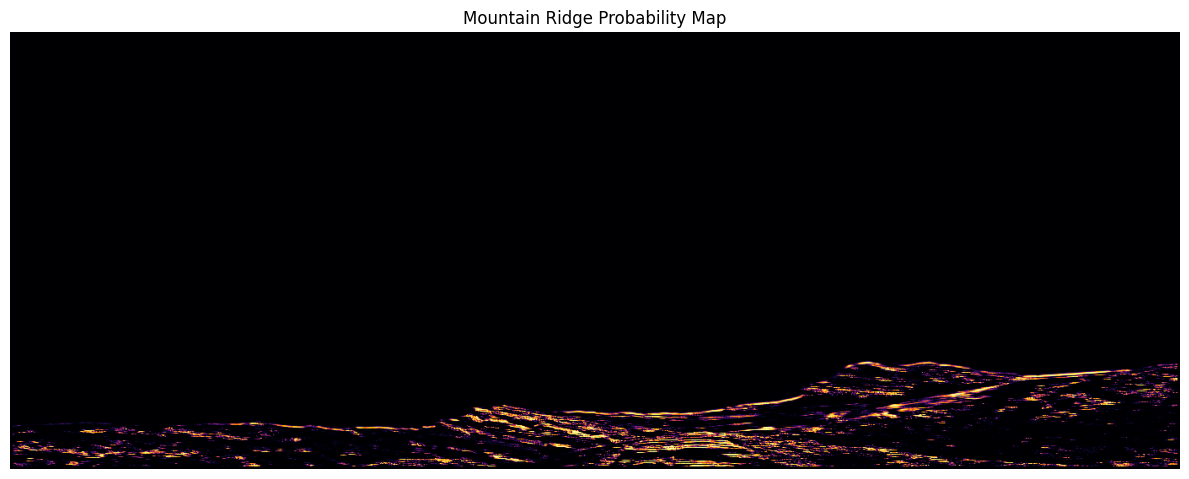

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.title("Mountain Ridge Probability Map")
plt.imshow(prob_map, cmap='inferno', vmin=0, vmax=1)
plt.axis('off')

plt.tight_layout()
plt.show()

In [26]:
import numpy as np

def find_ridge(prob_map, delta=5, epsilon=1e-6):
    H, W = prob_map.shape
    cost = np.full((H, W), np.inf)
    backtrack = np.full((H, W), -1, dtype=int)

    # Convert prob_map to cost map using negative log
    log_cost = -np.log(prob_map + epsilon)

    # Initialize first column
    cost[:, 0] = log_cost[:, 0]

    for x in range(1, W):
        for y in range(H):
            y_min = max(y - delta, 0)
            y_max = min(y + delta + 1, H)
            for yy in range(y_min, y_max):
                transition_cost = abs(y - yy)
                total_cost = cost[yy, x-1] + transition_cost + log_cost[y, x]
                if total_cost < cost[y, x]:
                    cost[y, x] = total_cost
                    backtrack[y, x] = yy

    # Backtrace the path
    ridge = np.zeros(W, dtype=int)
    ridge[-1] = np.argmin(cost[:, -1])
    for x in range(W - 2, -1, -1):
        ridge[x] = backtrack[ridge[x + 1], x + 1]

    return ridge

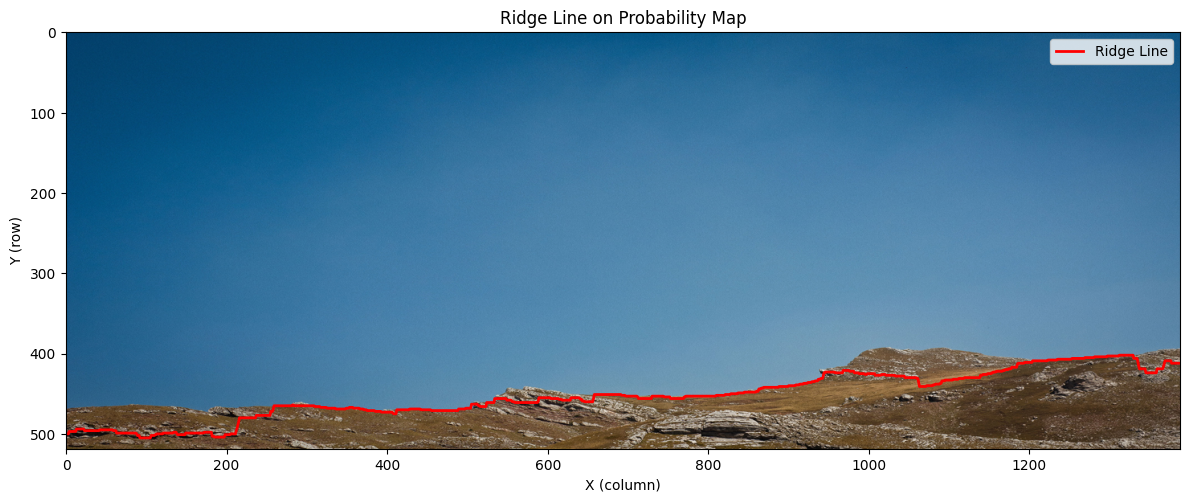

In [27]:
ridge = find_ridge(prob_map)

def plot_ridge(image, ridge):
    plt.figure(figsize=(12, 6))
    plt.imshow(image)
    plt.plot(range(len(ridge)), ridge, color='red', linewidth=2, label='Ridge Line')
    plt.title('Ridge Line on Probability Map')
    plt.xlabel('X (column)')
    plt.ylabel('Y (row)')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_ridge(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ridge)